In [1]:
import math
from functools import partial
import numpy as np
import pandas as pd
from scipy.optimize import linprog, minimize, differential_evolution, NonlinearConstraint
import matplotlib.pyplot as plt

import sys
sys.path.append("./../app")

import nordpool
import smhi

In [2]:
LONGITUDE = 12.1
LATITUDE = 57.6
AREA = "SN3"

In [3]:
# Constants
k1 = 1/540000
k2 = 1.5625*k1
K = k1 + k2


In [4]:
# Nordpool prices
from datetime import date
prices = nordpool.fetch_nordpool_data(AREA)
prices = np.asarray(prices)
prices = prices[prices != 0]
prices

array([13.39, 12.21, 12.01, 12.5 , 13.9 , 14.32, 14.01, 12.06, 11.6 ,
        9.21,  3.45])

In [5]:
temperatures = smhi.fetch_smhi_temperatures(LONGITUDE, LATITUDE)
temperatures = np.insert(temperatures, 0, temperatures[0])  # Use forecast for next hour as the current temperature (for testing only, this should be replaced with a proper outdoor sensor when run in production)

temperatures = np.asarray(temperatures[:len(prices)])
temperatures

array([12.4, 12.4, 12.3, 11.9, 11.5, 10.9, 10.8, 10.9, 10.8, 10.5, 10. ])

In [6]:
len(prices) == len(temperatures)

True

In [7]:
# Forecasted outdoor temperature
T_out = np.array(temperatures)

In [8]:
# Initial guess
def heating_curve(slope: float, T_out: float) -> float:
    return 20 + (-0.16 * slope) * (T_out - 20)

def inverse_heating_curve(slope: float, T_fr: float) -> float:
    return (T_fr - 20) / (-0.16 * slope) + 20

T_fr_0 = np.asarray(list(map(partial(heating_curve, 4.7), T_out)))
T_fr_0

array([25.7152, 25.7152, 25.7904, 26.0912, 26.392 , 26.8432, 26.9184,
       26.8432, 26.9184, 27.144 , 27.52  ])

In [9]:
def objective(x: np.ndarray):
    # return x.sum() / 19.5 # Minimize energy
    return (x * prices).sum() / (prices.sum()) # Minimize cost

def _analytical_solution(T_in_0: float, T_fr: float, T_out: float, t: float = 3600):
    T_w = (k2*T_fr + k1*T_out)/K
    delta = T_in_0 - T_w
    return T_w + delta*math.exp(-K*t)

def simulation(T_fr: np.ndarray):
    T_ins = []
    T_in = 19.5
    T_ins.append(T_in)

    for (Tfr, Tout) in zip(T_fr, T_out):
        T_in = _analytical_solution(T_in, Tfr, Tout)
        T_ins.append(T_in)

    return T_ins

def temperature_span_constraint(x: np.ndarray):
    T_ins = simulation(x)
    lower = np.array(T_ins) - 17
    upper = 22 - np.array(T_ins)
    return np.concatenate([lower, upper])

def final_temperature_constraint(x: np.ndarray):
    return simulation(x)[-1] - 19.5


In [10]:
res = minimize(
    objective,
    T_fr_0,
    method="SLSQP",
    constraints=[
        {
            "type": "ineq",
            "fun": temperature_span_constraint,
        },
        {
            "type": "eq",
            "fun": final_temperature_constraint
        }
    ],
    bounds=[(19, 50)]*len(prices),
    options={
        "maxiter": 500,
    }
)

In [11]:
res

     fun: 21.82254980770162
     jac: array([0.10407233, 0.09490085, 0.09334683, 0.09715533, 0.10803628,
       0.11130118, 0.10889173, 0.09373546, 0.09015989, 0.07158399,
       0.02681494])
 message: 'Optimization terminated successfully'
    nfev: 361
     nit: 30
    njev: 30
  status: 0
 success: True
       x: array([19.        , 19.        , 19.        , 19.        , 19.        ,
       19.        , 19.        , 19.        , 19.        , 46.81750904,
       50.        ])

In [12]:
simulation(res.x)

[19.5,
 19.447904581984496,
 19.396691568693072,
 19.34568500923131,
 19.292898393101865,
 19.23836187133284,
 19.180783075225172,
 19.12351855810806,
 19.067885005670156,
 19.012532783217527,
 19.243439787705043,
 19.499999999998444]

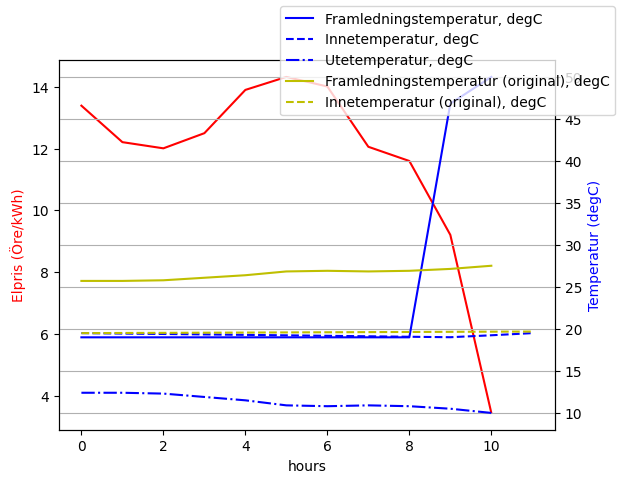

In [13]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(prices, 'r')
ax2.plot(res.x, 'b-', label="Framledningstemperatur, degC")
ax2.plot(simulation(res.x), 'b--', label="Innetemperatur, degC")
ax2.plot(T_out, 'b-.', label="Utetemperatur, degC")
ax2.plot(T_fr_0, 'y', label="Framledningstemperatur (original), degC")
ax2.plot(simulation(T_fr_0), 'y--', label="Innetemperatur (original), degC")

ax1.set_xlabel('hours')
ax1.set_ylabel('Elpris (Öre/kWh)', color='r')
ax2.set_ylabel('Temperatur (degC)', color='b')

fig.legend()
plt.grid()


In [14]:
print("Optimal framledningstemperatur just nu:",res.x[0], "degC")
print("Styrsignal till VP (fejkad utetemperatur):", inverse_heating_curve(4.7, res.x[0]), "degC")
print("Besparing:", (1 - (res.x*prices).sum() / (T_fr_0*prices).sum())*100,"%")

Optimal framledningstemperatur just nu: 19.000000000000203 degC
Styrsignal till VP (fejkad utetemperatur): 21.329787234042286 degC
Besparing: 17.50545389673388 %


In [15]:
def T_eff(T_out: float, wind_speed: float) -> float:
    return 13.12 + 0.61215*T_out - 13.956*wind_speed**0.16 +0.48669*T_out*wind_speed**0.16

def trial(T_in_0: float, T_out: float, t: float = 3600):
    delta = T_in_0 - T_out
    return T_out + delta*math.exp(-k1*t)

In [16]:
trial(36.6, 9, 3600*6)

35.51778852060412